In [1]:
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import preprocess_input
import numpy as np
from keras.utils import to_categorical
import cv2
import tensorflow as tf
tf.data


X = np.load("selected_images.npy")     # (num_samples, 240, 240), grayscale görüntüler
y = np.load("selected_labels.npy") 
print(X.shape)

print(y.shape)
print(X.dtype)

2025-05-05 15:43:07.718068: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-05 15:43:07.803176: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-05 15:43:07.839621: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-05 15:43:07.850826: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-05 15:43:07.902907: I tensorflow/core/platform/cpu_feature_guar

(45000, 240, 240)
(45000,)
uint8


In [2]:



indices = np.random.choice(len(X),30000,replace=False)
X = X[indices]
y = y[indices]


print(X.shape)


print(y.shape)

(30000, 240, 240)
(30000,)


In [3]:

X_resized = np.array([cv2.resize(img, (224, 224)) for img in X])

X_rgb = np.stack([X_resized]*3, axis=-1) 


y_encoded = to_categorical(y, num_classes=3)
print(y_encoded)


[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]


0


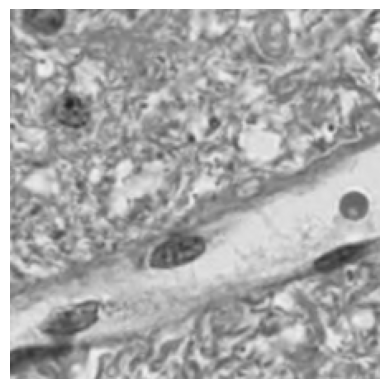

In [4]:
import matplotlib.pyplot as plt 

image = X_rgb[8]
print(y[8])

plt.imshow(image)
plt.axis('off')
plt.show()

In [5]:
del X_resized
del X

0


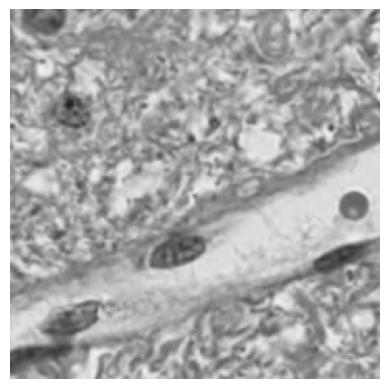

In [6]:
X_rgb = X_rgb.astype(np.float32)

X_processed = X_rgb/ 255.0


image = X_processed[8]
print(y[8])

plt.imshow(image)
plt.axis('off')
plt.show()

In [7]:
import gc

X_train, X_val, y_train, y_val = train_test_split(
    X_processed, y_encoded, test_size=0.2, stratify=y, random_state=42
)
del X_processed
del y_encoded

gc.collect()


3969

In [8]:
# def data_generator(batch_size, data_path='data.npy', label_path='labels.npy'):
#     data = np.load(data_path, mmap_mode='r')    # Load in read-only memory-mapped mode
#     labels = np.load(label_path, mmap_mode='r')
#     num_samples = data.shape[0]

#     while True:  # Infinite loop for Keras
#         for i in range(0, num_samples, batch_size):
#             X_batch = data[i:i+batch_size]
#             y_batch = labels[i:i+batch_size]
#             yield X_batch, y_batch

In [9]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

for layer in base_model.layers[:-2]:  
    layer.trainable = False
x = GlobalAveragePooling2D()(base_model.output)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(128, activation='relu')(x)
output = Dense(3, activation="softmax")(x)

I0000 00:00:1746449002.516960 2101430 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1746449002.587460 2101430 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1746449002.590165 2101430 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1746449002.593135 2101430 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [ ]:

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Reduce learning rate when validation loss plateaus
lr = ReduceLROnPlateau(
    monitor='val_loss',      # or 'val_accuracy'
    factor=0.5,              # reduce LR by this factor
    patience=1,              # after 3 epochs of no improvement
    min_lr=1e-6,             # don't go lower than this
    verbose=0
)
es = EarlyStopping(
    monitor='val_loss',   # or 'val_accuracy'
    patience=4,           # wait longer than lr_scheduler
    restore_best_weights=True,
    verbose=0
)
model = Model(inputs=base_model.input, outputs=output)
model.summary()
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 14,797,251 (56.45 MB)

 Trainable params: 2,442,371 (9.32 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

In [11]:
print(y_train.shape)

(24000, 3)


In [12]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32
)

Epoch 1/15


/home/ai1/miniconda3/envs/thesis/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(
I0000 00:00:1746449019.044679 2101694 service.cc:146] XLA service 0x71ef8c0049d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746449019.044870 2101694 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-05-05 15:43:39.083925: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-05 15:43:39.225311: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2025-05-05 15:43:39.587869: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memor

  6/750 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.3682 - loss: 1.1521

I0000 00:00:1746449023.270793 2101694 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5751 - loss: 0.8951

2025-05-05 15:44:04.201533: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 477.70MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-05-05 15:44:04.204397: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 532.01MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-05-05 15:44:04.231355: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 408.14MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-05-05 15:44:04.231373: W external/local_tsl/tsl/framewor

750/750 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.5751 - loss: 0.8950 - val_accuracy: 0.6710 - val_loss: 0.7351
Epoch 2/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.6976 - loss: 0.6961 - val_accuracy: 0.7232 - val_loss: 0.6598
Epoch 3/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.7283 - loss: 0.6404 - val_accuracy: 0.7372 - val_loss: 0.6361
Epoch 4/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.7620 - loss: 0.5829 - val_accuracy: 0.7482 - val_loss: 0.6026
Epoch 5/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.7748 - loss: 0.5436 - val_accuracy: 0.7612 - val_loss: 0.5806
Epoch 6/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.7941 - loss: 0.5079 - val_accuracy: 0.7748 - val_loss: 0.5397
Epoch 7/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.8190 - loss: 0.4519 - val_accuracy: 0.7553 - val_loss: 0.6032
Epoch 8/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.8328 - loss: 0.4158 - val_accurac

In [13]:
model.save('vgg_model.keras')

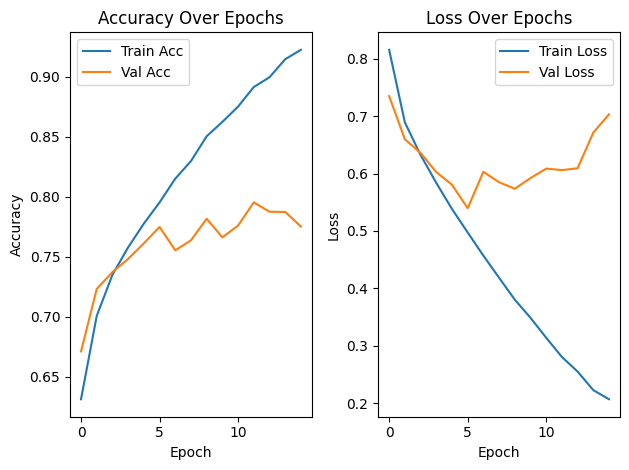

In [14]:
import matplotlib.pyplot as plt 

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

/home/ai1/miniconda3/envs/thesis/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step


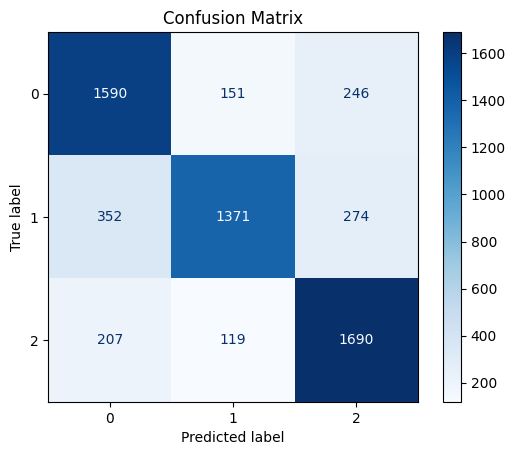

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# 🔮 Tahminleri al
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# ✅ y_val one-hot encoded ise, önce index formatına çevir
y_true = np.argmax(y_val, axis=1)

# 🧮 Confusion matrix hesapla
cm = confusion_matrix(y_true, y_pred)

# 🎨 Confusion matrix'i çiz
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_true))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()